<a href="https://colab.research.google.com/github/Syilun/Deep-Learning-algorithms/blob/master/anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [ ]:
normal_no = 1
abnormal_no = 9

x_normal = x_train[y_train == normal_no]
x_test_normal = x_test[y_test == normal_no]
x_abnormal = np.concatenate((x_train[y_train == abnormal_no], x_test[y_test == abnormal_no]))

x_normal = np.expand_dims(x_normal, axis=-1)
x_test_normal = np.expand_dims(x_test_normal, axis=-1)
x_abnormal = np.expand_dims(x_abnormal, axis=-1)

# For Dense autoencoder
# x_normal = x_normal.reshape((x_normal.shape[0], -1))
# x_test_normal = x_test_normal.reshape((x_test_normal.shape[0], -1))
# x_abnormal = x_abnormal.reshape((x_abnormal.shape[0], -1))

In [ ]:
x_normal.shape, x_test_normal.shape , x_abnormal.shape

((6742, 28, 28, 1), (1135, 28, 28, 1), (6958, 28, 28, 1))

In [ ]:
x_normal = x_normal / 255.
x_test_normal = x_test_normal / 255.
x_abnormal = x_abnormal / 255.

In [ ]:
# Model1: Unet with Conv2DTranspose
activation = 'selu'
input_layer = Input(shape=(28, 28, 1))
l = Conv2D(filters=8, kernel_size=(3,3), activation=activation, padding='same')(input_layer)
c1 = Conv2D(filters=8, kernel_size=(3,3), activation=activation, padding='same')(l)
l = MaxPool2D(strides=(2,2))(l)
l = Conv2D(filters=16, kernel_size=(3,3), activation=activation, padding='same')(l)
c2 = Conv2D(filters=16, kernel_size=(3,3), activation=activation, padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
c3 = Conv2D(filters=32, kernel_size=(3,3), activation=activation, padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3), c2], axis=-1)
l = Conv2D(filters=32, kernel_size=(2,2), activation=activation, padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), c1], axis=-1)
l = Conv2D(filters=16, kernel_size=(2,2), activation=activation, padding='same')(l)
l = Conv2D(filters=64, kernel_size=(1,1), activation=activation)(l)
output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
                                                         
model = Model(input_layer, output_layer)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 14, 14, 8)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 16)   1168        max_pooling2d[0][0]              
_______________________________________________________________________________________

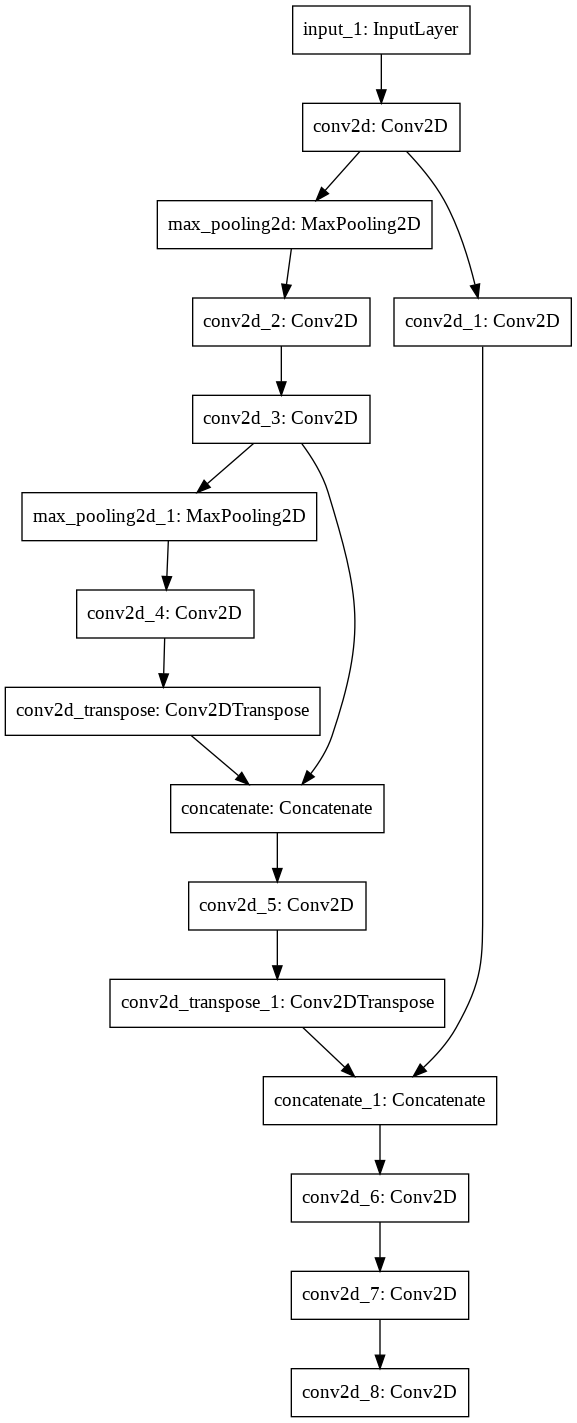

In [ ]:
keras.utils.plot_model(model)

In [ ]:
# # Model 2: Dense encoder
# inputs = Input((784,))
# x = Dense(100, activation='tanh')(inputs)
# x = Dense(50, activation='tanh')(x)
# x = Dense(25, activation='tanh')(x)
# x = Dense(50, activation='tanh')(x)
# x = Dense(100, activation='tanh')(x)
# x = Dense(784, activation='sigmoid')(x)
# model = Model(inputs, x)
# model.summary()

In [ ]:
model.compile(optimizer= keras.optimizers.adam(), loss='mse') # 每個pixel一個一個去比，平均差異。

In [ ]:
h = model.fit(x_normal, x_normal, batch_size=128, epochs=24)

Epoch 1/24
6742/6742 [==============================] - 9s 1ms/step - loss: 0.0400
Epoch 2/24
6742/6742 [==============================] - 2s 337us/step - loss: 0.0018
Epoch 3/24
6742/6742 [==============================] - 2s 336us/step - loss: 0.0011
Epoch 4/24
6742/6742 [==============================] - 2s 339us/step - loss: 7.8018e-04
Epoch 5/24
6742/6742 [==============================] - 2s 337us/step - loss: 5.9963e-04
Epoch 6/24
6742/6742 [==============================] - 2s 337us/step - loss: 4.7900e-04
Epoch 7/24
6742/6742 [==============================] - 2s 336us/step - loss: 3.9430e-04
Epoch 8/24
6742/6742 [==============================] - 2s 337us/step - loss: 3.3241e-04
Epoch 9/24
6742/6742 [==============================] - 2s 336us/step - loss: 2.9072e-04
Epoch 10/24
6742/6742 [==============================] - 2s 336us/step - loss: 2.6150e-04
Epoch 11/24
6742/6742 [==============================] - 2s 337us/step - loss: 2.4033e-04
Epoch 12/24
6742/6742 [==========

In [ ]:
pred_normal = model.predict(x_test_normal)
pred_abnormal = model.predict(x_abnormal)
pred_train = model.predict(x_normal)

In [ ]:
pred_normal.shape, pred_abnormal.shape, pred_train.shape

((1135, 28, 28, 1), (6958, 28, 28, 1), (6742, 28, 28, 1))

In [ ]:
def mse(x, y):
    return (np.square(x - y)).mean(axis=(1,2,3))

In [ ]:
error_normal = mse(pred_normal, x_test_normal)
error_abnormal = mse(pred_abnormal, x_abnormal)
error_train_normal = mse(pred_train, x_normal)

In [ ]:
error_normal.shape, error_abnormal.shape, error_train_normal.shape

((1135,), (6958,), (6742,))

In [ ]:
np.mean(error_normal), np.mean(error_abnormal), np.mean(error_train_normal)

(0.00014200196705698635, 0.0004962851388389909, 0.00014274429688681986)

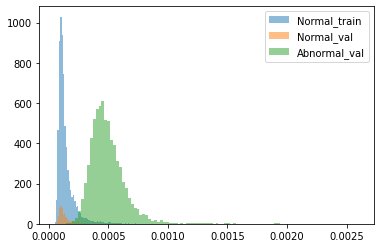

In [ ]:
plt.hist(error_train_normal, bins=100, alpha=0.5) # Blue
plt.hist(error_normal, bins=100, alpha=0.5) # Orange
plt.hist(error_abnormal, bins=100, alpha=0.5) # Green
plt.legend(['Normal_train', 'Normal_val', 'Abnormal_val'])
plt.show()